In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
plt.style.use('ggplot')
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.util import ngrams
from nltk.corpus import stopwords
stop=set(stopwords.words('english'))
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from collections import defaultdict
from collections import  Counter
from sklearn.model_selection import train_test_split
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.initializers import Constant
from keras.layers import (LSTM, 
                          Embedding, 
                          BatchNormalization,
                          Dense, 
                          TimeDistributed, 
                          Dropout, 
                          Bidirectional,
                          Flatten, 
                          GlobalMaxPool1D)
from nltk.tokenize import word_tokenize
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers.embeddings import Embedding
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from sklearn.metrics import (
    precision_score, 
    recall_score, 
    f1_score, 
    classification_report,
    accuracy_score
)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
movies = pd.read_csv("/content/drive/My Drive/movie.csv")
genome_scores = pd.read_csv("/content/drive/My Drive/genome_scores.csv")
genome_tags = pd.read_csv("/content/drive/My Drive/genome_tags.csv")
plot = pd.read_csv("/content/drive/My Drive/wiki_movie_plots_deduped.csv")
reviews = pd.read_csv("/content/drive/My Drive/metacritic_reviews.csv")

In [ ]:
plot.rename(columns={'Title': 'title'}, inplace=True)

In [ ]:
movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
27273,131254,Kein Bund für's Leben (2007),Comedy
27274,131256,"Feuer, Eis & Dosenbier (2002)",Comedy
27275,131258,The Pirates (2014),Adventure
27276,131260,Rentun Ruusu (2001),(no genres listed)


In [ ]:
movies['title'] = movies['title'].str.replace(r"\(.*\)","")

In [ ]:
movies['title'] = movies['title'].str.rstrip()

In [ ]:
df = pd.merge(movies, plot ,  how='left', left_on='title', right_on='title')

In [ ]:
df = df[df['Plot'].notna()]

In [ ]:
df = df.reset_index()

In [ ]:
df

,index,movieId,title,genres,Release Year,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995.0,American,John Lasseter,"Tim Allen, Tom Hanks (voices)",animated film,https://en.wikipedia.org/wiki/Toy_Story,In a world where toys are living things who pr...
1,1,2,Jumanji,Adventure|Children|Fantasy,1995.0,American,Joe Johnston,"Robin Williams, Bonnie Hunt, Kirsten Dunst, Br...","family, fantasy",https://en.wikipedia.org/wiki/Jumanji_(film),"In 1869, near Brantford, New Hampshire, two br..."
2,2,3,Grumpier Old Men,Comedy|Romance,1995.0,American,Howard Deutch,"Jack Lemmon, Walter Matthau, Ann-Margret, Soph...",comedy,https://en.wikipedia.org/wiki/Grumpier_Old_Men,The feud between Max (Walter Matthau) and John...
3,3,4,Waiting to Exhale,Comedy|Drama|Romance,1995.0,American,Forest Whitaker,"Whitney Houston, Angela Bassett, Loretta Devin...",drama,https://en.wikipedia.org/wiki/Waiting_to_Exhale,"""Friends are the People who let you be yoursel..."
4,4,5,Father of the Bride Part II,Comedy,1995.0,American,Charles Shyer,"Steve Martin, Diane Keaton, Martin Short, Kimb...",comedy,https://en.wikipedia.org/wiki/Father_of_the_Br...,The film begins five years after the events of...
...,...,...,...,...,...,...,...,...,...,...,...
11988,29222,131152,The Fat Spy,Comedy,1966.0,American,Joseph Cates,"Phyllis Diller, Jack E. Leonard, Brian Donlevy...",comedy,https://en.wikipedia.org/wiki/The_Fat_Spy,"A mostly-deserted island, which is believed to..."
11989,29230,131168,Phoenix,Drama,1998.0,American,Danny Cannon,"Ray Liotta, Anjelica Huston, Anthony LaPaglia,...",crime,https://en.wikipedia.org/wiki/Phoenix_(1998_film),"In Phoenix, Arizona, Harry Collins is a cop wh..."
11990,29235,131180,Dead Rising: Watchtower,Action|Horror|Thriller,2015.0,Canadian,Zach Lipovsky,"Jesse Metcalfe, Dennis Haysbert, Virginia Madsen",zombie horror,https://en.wikipedia.org/wiki/Dead_Rising:_Wat...,Set between the events of Dead Rising 2 and De...
11991,29237,131237,What Men Talk About,Comedy,2010.0,Russian,Dmitry Dyashchenko,NaN,comedy,https://en.wikipedia.org/wiki/What_Men_Talk_About,"What Men Talk About? Of course, women. But als..."


In [ ]:
reviews

,critic_name,media,title,review_date,individual_meta_score,text
0,M. E. Russell,Portland Oregonian,Hustle & Flow,NaN,100,"The writing, acting and filmmaking make Hustle..."
1,Owen Gleiberman,Entertainment Weekly,Hustle & Flow,NaN,91,The home-studio recording sequences in Hustle ...
2,Ann Hornaday,Washington Post,Hustle & Flow,NaN,90,"The performances are accomplished, but the rea..."
3,Stephanie Zacharek,Salon,Hustle & Flow,NaN,90,In a world of movies that try far too hard to ...
4,Jami Bernard,New York Daily News,Hustle & Flow,NaN,88,The feel-good movie of the summer. And the son...
...,...,...,...,...,...,...
246950,John Patterson,L.A. Weekly,The Quiet American,NaN,70,"Noyce has made a good-looking, intelligent sta..."
246951,Rick Groen,The Globe and Mail (Toronto),The Quiet American,NaN,63,The result is a rarity on the modern screen --...
246952,Jonathan Foreman,New York Post,The Quiet American,NaN,63,"It's a shame that, on top of everything else, ..."
246953,Jami Bernard,New York Daily News,The Quiet American,NaN,50,The movie adds nothing to the political dialog...


In [ ]:
reviews = reviews.astype(str) 

In [ ]:
reviews = reviews.groupby("title")['text'].apply(' '.join).reset_index()

In [ ]:
reviews

,title,text
0,!Women Art Revolution,"These interviews form the backbone of !W.A.R.,..."
1,#Horror,Not every gamble works: The girls' intrusive B...
2,$9.99,"Using the droll, wise stories of Etgar Keret a..."
3,$pent,Has a warm and intimate feel that helps push i...
4,'71,"Swift and exciting, with no taste for the usua..."
...,...,...
12024,xXx: State of the Union,This is a B movie rooted in gut-level stirring...
12025,À Tout de Suite (Right Now),It's hard to imagine many films surpassing or ...
12026,À cause d'un garçon,"While Cazeneuve's story is about gay love, it ..."
12027,Æon Flux,"It's all so geekily gorgeous, it hardly matter..."


In [ ]:
df = pd.merge(df, reviews ,  how='left', left_on='title', right_on='title')

In [ ]:
df = df[df['text'].notna()]

In [ ]:
df

,index,movieId,title,genres,Release Year,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot,text
0,0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995.0,American,John Lasseter,"Tim Allen, Tom Hanks (voices)",animated film,https://en.wikipedia.org/wiki/Toy_Story,In a world where toys are living things who pr...,"With ""instant classic"" written all over it, To..."
1,1,2,Jumanji,Adventure|Children|Fantasy,1995.0,American,Joe Johnston,"Robin Williams, Bonnie Hunt, Kirsten Dunst, Br...","family, fantasy",https://en.wikipedia.org/wiki/Jumanji_(film),"In 1869, near Brantford, New Hampshire, two br...",The result is a thrill ride with enough plunge...
2,2,3,Grumpier Old Men,Comedy|Romance,1995.0,American,Howard Deutch,"Jack Lemmon, Walter Matthau, Ann-Margret, Soph...",comedy,https://en.wikipedia.org/wiki/Grumpier_Old_Men,The feud between Max (Walter Matthau) and John...,Grumpier is a welcome continuation that leaves...
4,4,5,Father of the Bride Part II,Comedy,1995.0,American,Charles Shyer,"Steve Martin, Diane Keaton, Martin Short, Kimb...",comedy,https://en.wikipedia.org/wiki/Father_of_the_Br...,The film begins five years after the events of...,nan What Meyers and Shyer have accomplished is...
5,5,6,Heat,Action|Crime|Thriller,1972.0,American,Paul Morrissey,"Joe Dallesandro, Sylvia Miles",drama,https://en.wikipedia.org/wiki/Heat_(1972_film),Joey Davis is an unemployed former child star ...,Stunningly made and incisively acted by a larg...
...,...,...,...,...,...,...,...,...,...,...,...,...
11970,29116,130622,The Circle,Documentary|Drama,1925.0,American,Frank Borzage,"Eleanor Boardman, Malcolm McGregor",romance drama,https://en.wikipedia.org/wiki/The_Circle_(1925...,"In the 1890s, young Lady Catherine (Joan Crawf...",The Circle is very much a plea for the preserv...
11971,29117,130622,The Circle,Documentary|Drama,2017.0,American,James Ponsoldt,James Ponsoldt (director/screenplay); Tom Hank...,"sci-fi, drama, thriller",https://en.wikipedia.org/wiki/The_Circle_(2017...,"When her car breaks down, Mae Holland contacts...",The Circle is very much a plea for the preserv...
11978,29162,131013,Get Hard,Comedy,2015.0,American,Etan Cohen,Will Ferrell\r\nKevin Hart\r\nAlison Brie\r\nE...,comedy,https://en.wikipedia.org/wiki/Get_Hard,James King is an extremely wealthy hedge fund ...,It matches up two comic actors and instead of ...
11987,29207,131122,Love Exposure,Action|Comedy|Drama|Romance,2008.0,Japanese,Shion Sono,"Atsuro Watabe, Itsuji Itao, Mami Nakamura, Hik...","romance, comedy, drama, art house & internatio...",https://en.wikipedia.org/wiki/Love_Exposure,The story follows Yū Honda (Takahiro Nishijima...,"The movie’s invigorating discourse on sin, lus..."


In [ ]:
 df.drop(df.columns.difference(['Plot','title', 'text', 'movieId']), 1, inplace=True)

In [ ]:
df = df.reset_index()

In [ ]:
df = df.drop(['index'], axis = 1)

In [ ]:
df.head()

,movieId,title,Plot,text
0,1,Toy Story,In a world where toys are living things who pr...,"With ""instant classic"" written all over it, To..."
1,2,Jumanji,"In 1869, near Brantford, New Hampshire, two br...",The result is a thrill ride with enough plunge...
2,3,Grumpier Old Men,The feud between Max (Walter Matthau) and John...,Grumpier is a welcome continuation that leaves...
3,5,Father of the Bride Part II,The film begins five years after the events of...,nan What Meyers and Shyer have accomplished is...
4,6,Heat,Joey Davis is an unemployed former child star ...,Stunningly made and incisively acted by a larg...


In [ ]:
genome = pd.merge(genome_scores, genome_tags ,  how='left', left_on='tagId', right_on='tagId')

In [ ]:
genome

,movieId,tagId,relevance,tag
0,1,1,0.02500,007
1,1,2,0.02500,007 (series)
2,1,3,0.05775,18th century
3,1,4,0.09675,1920s
4,1,5,0.14675,1930s
...,...,...,...,...
11709763,131170,1124,0.58775,writing
11709764,131170,1125,0.01075,wuxia
11709765,131170,1126,0.01575,wwii
11709766,131170,1127,0.11450,zombie


In [ ]:
df = pd.merge(df, genome ,  how='left', left_on='movieId', right_on='movieId')

In [ ]:
df

,movieId,title,Plot,text,tagId,relevance,tag
0,1,Toy Story,In a world where toys are living things who pr...,"With ""instant classic"" written all over it, To...",1.0,0.02500,007
1,1,Toy Story,In a world where toys are living things who pr...,"With ""instant classic"" written all over it, To...",2.0,0.02500,007 (series)
2,1,Toy Story,In a world where toys are living things who pr...,"With ""instant classic"" written all over it, To...",3.0,0.05775,18th century
3,1,Toy Story,In a world where toys are living things who pr...,"With ""instant classic"" written all over it, To...",4.0,0.09675,1920s
4,1,Toy Story,In a world where toys are living things who pr...,"With ""instant classic"" written all over it, To...",5.0,0.14675,1930s
...,...,...,...,...,...,...,...
5146204,131168,Phoenix,"In Phoenix, Arizona, Harry Collins is a cop wh...",There is intrigue. There is suspense. Guilt - ...,1124.0,0.03225,writing
5146205,131168,Phoenix,"In Phoenix, Arizona, Harry Collins is a cop wh...",There is intrigue. There is suspense. Guilt - ...,1125.0,0.04800,wuxia
5146206,131168,Phoenix,"In Phoenix, Arizona, Harry Collins is a cop wh...",There is intrigue. There is suspense. Guilt - ...,1126.0,0.51925,wwii
5146207,131168,Phoenix,"In Phoenix, Arizona, Harry Collins is a cop wh...",There is intrigue. There is suspense. Guilt - ...,1127.0,0.06700,zombie


In [ ]:
df = df[df['relevance'].notna()]

In [ ]:
df = df[df['tag'].notna()]

In [ ]:
df = df[df['Plot'].notna()]

In [ ]:
df = df.reset_index()

In [ ]:
df

,index,movieId,title,Plot,text,tagId,relevance,tag
0,0,1,Toy Story,In a world where toys are living things who pr...,"With ""instant classic"" written all over it, To...",1.0,0.02500,007
1,1,1,Toy Story,In a world where toys are living things who pr...,"With ""instant classic"" written all over it, To...",2.0,0.02500,007 (series)
2,2,1,Toy Story,In a world where toys are living things who pr...,"With ""instant classic"" written all over it, To...",3.0,0.05775,18th century
3,3,1,Toy Story,In a world where toys are living things who pr...,"With ""instant classic"" written all over it, To...",4.0,0.09675,1920s
4,4,1,Toy Story,In a world where toys are living things who pr...,"With ""instant classic"" written all over it, To...",5.0,0.14675,1930s
...,...,...,...,...,...,...,...,...
5144803,5146204,131168,Phoenix,"In Phoenix, Arizona, Harry Collins is a cop wh...",There is intrigue. There is suspense. Guilt - ...,1124.0,0.03225,writing
5144804,5146205,131168,Phoenix,"In Phoenix, Arizona, Harry Collins is a cop wh...",There is intrigue. There is suspense. Guilt - ...,1125.0,0.04800,wuxia
5144805,5146206,131168,Phoenix,"In Phoenix, Arizona, Harry Collins is a cop wh...",There is intrigue. There is suspense. Guilt - ...,1126.0,0.51925,wwii
5144806,5146207,131168,Phoenix,"In Phoenix, Arizona, Harry Collins is a cop wh...",There is intrigue. There is suspense. Guilt - ...,1127.0,0.06700,zombie


In [ ]:
pivot=df.pivot_table(index='movieId',columns='tagId',values='relevance').fillna(0)

In [ ]:
pivot

tagId,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0,31.0,32.0,33.0,34.0,35.0,36.0,37.0,38.0,39.0,40.0,...,1089.0,1090.0,1091.0,1092.0,1093.0,1094.0,1095.0,1096.0,1097.0,1098.0,1099.0,1100.0,1101.0,1102.0,1103.0,1104.0,1105.0,1106.0,1107.0,1108.0,1109.0,1110.0,1111.0,1112.0,1113.0,1114.0,1115.0,1116.0,1117.0,1118.0,1119.0,1120.0,1121.0,1122.0,1123.0,1124.0,1125.0,1126.0,1127.0,1128.0
movieId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.02500,0.02500,0.05775,0.09675,0.14675,0.21700,0.06700,0.26275,0.26200,0.03200,0.57700,0.11625,0.18800,0.00800,0.03675,0.28175,0.00700,0.11050,0.67050,0.18450,0.33025,0.28250,0.05700,0.01550,0.08500,0.08100,0.19500,0.07150,0.89200,0.67625,0.03875,0.22800,0.40200,0.03875,0.02675,0.33025,0.10100,0.01250,0.01850,0.01425,...,0.10850,0.60425,0.41050,0.44500,0.33725,0.02175,0.04075,0.06250,0.04375,0.10075,0.00475,0.19225,0.25850,0.00900,0.02775,0.29925,0.04675,0.01025,0.02725,0.73700,0.11200,0.05125,0.04375,0.05350,0.12575,0.77675,0.14500,0.11275,0.04200,0.10250,0.03950,0.01800,0.04575,0.03275,0.12500,0.04150,0.01925,0.03625,0.07775,0.02300
2,0.03975,0.04375,0.03775,0.04800,0.11025,0.07250,0.04775,0.10975,0.09925,0.02050,0.06775,0.08900,0.22575,0.00625,0.00300,0.03475,0.00950,0.18975,0.64600,0.40025,0.45100,0.60200,0.15100,0.28100,0.07600,0.14350,0.11675,0.04350,0.98100,0.10550,0.00825,0.06650,0.08575,0.05300,0.04525,0.14650,0.07750,0.02900,0.02275,0.02475,...,0.08925,0.32475,0.19125,0.32550,0.17675,0.02650,0.03500,0.04125,0.02775,0.04750,0.00575,0.04700,0.15700,0.01425,0.02400,0.31600,0.08850,0.02375,0.01300,0.24450,0.10075,0.03425,0.02475,0.26450,0.39025,0.18000,0.18725,0.14750,0.01500,0.05700,0.04175,0.01925,0.01725,0.02425,0.12550,0.02250,0.01550,0.01475,0.09025,0.01875
3,0.04350,0.05475,0.02800,0.07700,0.05400,0.06850,0.05600,0.18500,0.04925,0.02675,0.02225,0.07100,0.09050,0.00475,0.00250,0.02875,0.01175,0.10400,0.16475,0.17375,0.28000,0.20775,0.08675,0.01700,0.04250,0.08375,0.12225,0.10800,0.41200,0.09525,0.00900,0.04750,0.06475,0.05925,0.02600,0.20950,0.04375,0.02350,0.05675,0.01300,...,0.10525,0.11400,0.21250,0.16575,0.03550,0.02450,0.04925,0.03825,0.03400,0.07225,0.01125,0.03875,0.13875,0.41600,0.04175,0.16800,0.06175,0.02050,0.04275,0.15525,0.17250,0.04275,0.04450,0.02325,0.03375,0.19950,0.02825,0.37075,0.02625,0.07325,0.04150,0.02675,0.02775,0.03425,0.15550,0.03675,0.01700,0.01950,0.09700,0.01850
5,0.04200,0.05275,0.05925,0.03675,0.07525,0.12525,0.02850,0.08500,0.02950,0.02875,0.03125,0.06150,0.07175,0.00650,0.00225,0.02775,0.01425,0.16100,0.16350,0.22650,0.27575,0.21075,0.10275,0.02250,0.04150,0.05100,0.19200,0.17150,0.15375,0.12225,0.01000,0.04175,0.07950,0.04050,0.03175,0.07250,0.03400,0.01925,0.04200,0.00600,...,0.10825,0.14700,0.18750,0.22100,0.08950,0.01350,0.04075,0.03550,0.03075,0.06625,0.00775,0.03850,0.13150,0.80675,0.02650,0.26975,0.05575,0.02100,0.02175,0.20825,0.11850,0.14150,0.03875,0.03475,0.04675,0.12000,0.02925,0.48900,0.02150,0.07450,0.04250,0.02825,0.02150,0.02600,0.14275,0.02075,0.01650,0.01675,0.10750,0.01825
6,0.02825,0.02550,0.01850,0.04550,0.09575,0.05500,0.04400,0.24200,0.12850,0.02550,0.01550,0.04400,0.08000,0.00675,0.00350,0.03225,0.01250,0.18250,0.92475,0.60200,0.33625,0.24075,0.04125,0.01150,0.21450,0.06775,0.07200,0.26600,0.08050,0.25275,0.01850,0.03300,0.20750,0.00975,0.02025,0.07000,0.06700,0.02250,0.11575,0.00650,...,0.84025,0.35350,0.32900,0.40500,0.07050,0.02225,0.04600,0.04125,0.06275,0.06550,0.00775,0.05675,0.67900,0.02050,0.03050,0.22875,0.06900,0.01725,0.02875,0.08600,0.07000,0.10675,0.04675,0.00900,0.02550,0.40750,0.03375,0.10925,0.06375,0.18800,0.04900,0.01825,0.02075,0.06000,0.29975,0.15525,0.03525,0.01950,0.06650,0.01900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [ ]:
credit_list = []

In [ ]:
credit_list.append(np.asarray(pivot.values.tolist(), dtype=np.float32))

In [ ]:
credit_list

[array([[0.025  , 0.025  , 0.05775, ..., 0.03625, 0.07775, 0.023  ],
        [0.03975, 0.04375, 0.03775, ..., 0.01475, 0.09025, 0.01875],
        [0.0435 , 0.05475, 0.028  , ..., 0.0195 , 0.097  , 0.0185 ],
        ...,
        [0.154  , 0.04025, 0.01975, ..., 0.00525, 0.07575, 0.01325],
        [0.042  , 0.03175, 0.017  , ..., 0.0095 , 0.0755 , 0.01625],
        [0.05975, 0.10375, 0.1785 , ..., 0.51925, 0.067  , 0.01725]],
       dtype=float32)]

In [ ]:
final = np.array(credit_list)

In [ ]:
final.shape

(1, 3733, 1128)

In [ ]:
df1 = df.drop_duplicates(subset=['movieId'])

In [ ]:
df1 = df1.reset_index()

In [ ]:
df1

,level_0,index,movieId,title,Plot,text,tagId,relevance,tag
0,0,0,1,Toy Story,In a world where toys are living things who pr...,"With ""instant classic"" written all over it, To...",1.0,0.02500,007
1,1128,1128,2,Jumanji,"In 1869, near Brantford, New Hampshire, two br...",The result is a thrill ride with enough plunge...,1.0,0.03975,007
2,2256,2256,3,Grumpier Old Men,The feud between Max (Walter Matthau) and John...,Grumpier is a welcome continuation that leaves...,1.0,0.04350,007
3,3384,3384,5,Father of the Bride Part II,The film begins five years after the events of...,nan What Meyers and Shyer have accomplished is...,1.0,0.04200,007
4,4512,4512,6,Heat,Joey Davis is an unemployed former child star ...,Stunningly made and incisively acted by a larg...,1.0,0.02825,007
...,...,...,...,...,...,...,...,...,...
3728,5136912,5138310,130496,Big Game,When Air Force One is shot down by terrorists ...,"Onni Tommila, Mr. Helander’s nephew, has an ex...",1.0,0.03275,007
3729,5138040,5139438,130520,Home,"On the run from their enemy, the so-called pla...","The combination of Home’s layered message, fun...",1.0,0.05875,007
3730,5140296,5141694,130578,The Gunman,Jim Terrier (Sean Penn) is a former special fo...,"Basically, The Gunman is a movie that asks aud...",1.0,0.15400,007
3731,5142552,5143952,131013,Get Hard,James King is an extremely wealthy hedge fund ...,It matches up two comic actors and instead of ...,1.0,0.04200,007


In [ ]:
import tensorflow as tf
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.layers import TimeDistributed, Dense, LSTM, Embedding, Dropout, Bidirectional, GlobalMaxPool1D
from tensorflow.python.keras.models import Model, Sequential
from keras.utils.np_utils import to_categorical# -------- other packages ------------------ #
import sys
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
import pickle

np.set_printoptions(threshold=sys.maxsize)
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

df = pd.read_csv("/content/drive/My Drive/wikidata.csv", delimiter = "\t", names = ["Sentence", "Keyword"])
df['Sentence'] = df['Sentence'].astype(str)
df['Keyword'] = df['Keyword'].astype(str)

def hasNumbers(inputString):
	return any(char.isdigit() for char in inputString)

def tag_keywords(all_keywords):
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts([all_keywords])
	all_keywords = [i for i in tokenizer.word_index.keys()]
	all_keywords = list(set(all_keywords))
	return all_keywords

# sentence cleaning
df['Sentence'] = df['Sentence'].apply(lambda x: x.replace(" – TechCrunch",""))
df['Keyword'] = df['Keyword'].apply(lambda x: tag_keywords(x))

sentence_column = []
keyword_column = []
for index, row in df.iterrows():
	new_keywords = []
	sentence = row['Sentence']
	keywords = row['Keyword']
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts([sentence])
	tokens = [i for i in tokenizer.word_index.keys()]
	for i in tokens:
		if i in keywords:
			if not hasNumbers(i):
				new_keywords.append(1)
		else:
			new_keywords.append(0)
	if sum(new_keywords) != 0:
		sentence_column.append(sentence)
		keyword_column.append(new_keywords)


tokenizer = Tokenizer(oov_token = "<UNK>")
tokenizer.fit_on_texts(sentence_column)
X = tokenizer.texts_to_sequences(sentence_column)
X = pad_sequences(X, padding = "post", truncating = "post", maxlen = 500, value = 0)
y = pad_sequences(keyword_column, padding = "post", truncating = "post", maxlen = 500, value = 0)
y = [to_categorical(i, num_classes = 2) for i in y]
embeddings_index = {}
# e_dat is an embedding file(glove)
f = open('/content/drive/My Drive/glove.6B.200d.txt','r')
for line in f:
	values = line.split()
	word = values[0]
	coefs = np.asarray(values[1:], dtype = "float32")
	embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

EMBEDDING_DIM = 200
word_index = tokenizer.word_index
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)
# Model creation
model = Sequential()
model.add(Embedding(len(word_index) + 1, 200, weights = [embedding_matrix]))
model.add(Bidirectional(LSTM(128, return_sequences = True, recurrent_dropout = 0.3)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(128, return_sequences = True, recurrent_dropout = 0.1)))
model.add(Dropout(0.5))
model.add(TimeDistributed(Dense(2, activation = "softmax")))
model.compile(loss="categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])
model.fit(X_train, np.array(y_train), batch_size = 32, epochs = 5, validation_split = 0.1)

# model save
model_json = model.to_json()
with open("/content/drive/My Drive/model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("/content/drive/My Drive/model.h5")
pickle.dump(tokenizer, open("tokenizer.pickle","wb"))
print("Saved model to disk")

json_file = open('/content/drive/My Drive/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = tf.keras.models.model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/drive/My Drive/model.h5")
print("Loaded model from disk")

test_output = loaded_model.predict(X_test)
test_output = np.argmax(test_output, axis = -1)


flattened_actual = (np.argmax(np.array(y_test), axis = -1)).flatten()
flattened_output = test_output.flatten()

print(classification_report(flattened_actual, flattened_output))




Loaded model from disk


In [ ]:
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer 
try:
  while True:
    input_ = input("Type in a headline:")
    new_t = Tokenizer()
    new_t.fit_on_texts([input_])
    tokens = [i for i in new_t.word_index.keys()]
#		print(tokens)
    actual_tokens = new_t.texts_to_sequences([input_])
    inv_map_tokens = {v: k for k, v in new_t.word_index.items()}
    actual_tokens = [inv_map_tokens[i] for i in actual_tokens[0]]
    tokens = actual_tokens
    input_ = tokenizer.texts_to_sequences([input_])
    input_ = pad_sequences(input_, padding = "post", truncating = "post", maxlen = 500, value = 0)
    output = loaded_model.predict([input_])
    output = np.argmax(output, axis = -1)
    where_ = np.where(output[0] == 1)[0]
    output_keywords = np.take(tokens, where_)
    lem= WordNetLemmatizer()
    output_keywords = [lem.lemmatize(word) for word in output_keywords if not word in set(stopwords.words('english'))]
    output_keywords = list(set(output_keywords))
#		print(tokens)
#		print(output)
    print(output_keywords)
    print(len(output_keywords))
except KeyboardInterrupt:
	pass

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
['16', 'famous', 'masterwork', 'trouble', 'entire', 'many', 'connected', 'call', 'majid', 'epic', 'anjali', 'save', 'perceives', 'begin', 'renaissance', 'track', 'helped', 'delf', 'law', 'day', "sartaj's", 'enforcement', 'ruthless', 'gaitonde', 'find', 'corrupt', "'nobody'", 'always', 'richness', 'troubled', 'corruption', 'power', 'sacred', 'caller', '25', 'upon', 'god', 'lie', 'police', 'privileged', 'biggie', 'appreciation', 'sometimes', "city's", 'bloodthirsty', 'indian', 'could', 'receives', 'politics', 'senior', 'wretched', 'manages', 'rather', 'busy', 'amid', 'standard', 'keep', 'game', 'blow', 'get', 'beneath', 'year', 'inspector', 'past', 'espionage', 'incident', 'mathur', 'set', 'threatens', 'criminal', 'interweaves', 'location', 'secretly', 'missing', 'ganesh', "india's", 'mumbai', 'shoot', 'city', 'life', 'demotivated', 'detail', 'powerful', 'web', 'tell', 'dig'

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
import string
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    lem= WordNetLemmatizer()
    text = text.split()
    text = [lem.lemmatize(word) for word in text if not word in set(stopwords.words('english'))]
    text = ' '.join(text)
    return text

In [ ]:
df1['text'] = df1['text'].apply(lambda x: clean_text(x))
df1['Plot'] = df1['Plot'].apply(lambda x: clean_text(x))

In [ ]:
df1['plot'] = df1['Plot'] + df1['text']

In [ ]:
df1

,level_0,index,movieId,title,Plot,text,tagId,relevance,tag,plot
0,0,0,1,Toy Story,world toy living thing pretend lifeless human ...,instant classic written toy story first fullle...,1.0,0.02500,007,world toy living thing pretend lifeless human ...
1,1128,1128,2,Jumanji,near brantford new hampshire two brother bury ...,result thrill ride enough plunge turn loopthel...,1.0,0.03975,007,near brantford new hampshire two brother bury ...
2,2256,2256,3,Grumpier Old Men,feud max walter matthau john jack lemmon coole...,grumpier welcome continuation leaf wanting ano...,1.0,0.04350,007,feud max walter matthau john jack lemmon coole...
3,3384,3384,5,Father of the Bride Part II,film begin five year event first one george ba...,nan meyers shyer accomplished create pleasant ...,1.0,0.04200,007,film begin five year event first one george ba...
4,4512,4512,6,Heat,joey davis unemployed former child star suppor...,stunningly made incisively acted large terrifi...,1.0,0.02825,007,joey davis unemployed former child star suppor...
...,...,...,...,...,...,...,...,...,...,...
3728,5136912,5138310,130496,Big Game,air force one shot terrorist leaving president...,onni tommila mr helander’s nephew expressive f...,1.0,0.03275,007,air force one shot terrorist leaving president...
3729,5138040,5139438,130520,Home,run enemy socalled planetdestroying gorg alien...,combination home’s layered message fun score c...,1.0,0.05875,007,run enemy socalled planetdestroying gorg alien...
3730,5140296,5141694,130578,The Gunman,jim terrier sean penn former special force sol...,basically gunman movie asks audience sympathiz...,1.0,0.15400,007,jim terrier sean penn former special force sol...
3731,5142552,5143952,131013,Get Hard,james king extremely wealthy hedge fund manage...,match two comic actor instead clashing canceli...,1.0,0.04200,007,james king extremely wealthy hedge fund manage...


In [ ]:
plot = df1['plot'].values

In [ ]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(plot)
vocab_length = len(word_tokenizer.word_index) + 1

In [ ]:
longest_train = max(plot, key=lambda sentence: len(word_tokenize(sentence)))
length_long_sentence = len(word_tokenize(longest_train))
padded_sentences = pad_sequences(word_tokenizer.texts_to_sequences(plot), 50, padding='post')

In [ ]:
embeddings_index = {}
# embedding file(glove)
f = open('/content/drive/My Drive/glove.6B.100d.txt','r')
for line in f:
	values = line.split()
	word = values[0]
	coefs = np.asarray(values[1:], dtype = "float32")
	embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
EMBEDDING_DIM = 100
word_index = word_tokenizer.word_index
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

In [ ]:
result = final[0, :, :]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split( padded_sentences, result, test_size=0.1, random_state=0)

In [ ]:
def BLSTM():
    model = Sequential()
    model.add(Embedding(input_dim=len(word_index)+1, 
                        output_dim=100, 
                        weights = [embedding_matrix],
                        input_length = 50))
    model.add(Bidirectional(LSTM(50, return_sequences = True, recurrent_dropout=0.2)))
    model.add(Bidirectional(LSTM( 256, return_sequences = True, recurrent_dropout=0.2)))
    model.add(GlobalMaxPool1D())
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(2048, activation = "relu"))
    model.add(Dense(1024, activation = "relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(1128, activation = 'sigmoid'))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

NameError: ignored

In [ ]:
def build_lrfn(lr_start=0.00001, lr_max=0.000075, 
               lr_min=0.000001, lr_rampup_epochs=20, 
               lr_sustain_epochs=0, lr_exp_decay=.8):
    
    def lrfn(epoch):
        if epoch < lr_rampup_epochs:
            lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
        elif epoch < lr_rampup_epochs + lr_sustain_epochs:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) * lr_exp_decay**(epoch - lr_rampup_epochs - lr_sustain_epochs) + lr_min
        return lr
    
    return lrfn

lrfn = build_lrfn()
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=1)

In [ ]:
model = BLSTM()
checkpoint = ModelCheckpoint(
    '/content/drive/My Drive/model_tag.h5', 
    monitor = 'val_loss', 
    verbose = 1, 
    save_best_only = True
)

history = model.fit(
    X_train, 
    y_train,
    epochs = 100,
    batch_size = 64,
    validation_data = [X_test, y_test],
    verbose = 1,
    callbacks = [checkpoint, lr_schedule],
    shuffle=True)


Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/100
53/53 [==============================] - ETA: 0s - loss: 0.2342
Epoch 00001: val_loss improved from inf to 0.00000, saving model to /content/drive/My Drive/model_tag.h5
53/53 [==============================] - 47s 886ms/step - loss: 0.2342 - val_loss: 0.0000e+00

Epoch 00002: LearningRateScheduler reducing learning rate to 1.325e-05.
Epoch 2/100
53/53 [==============================] - ETA: 0s - loss: 0.2327
Epoch 00002: val_loss did not improve from 0.00000
53/53 [==============================] - 45s 848ms/step - loss: 0.2327 - val_loss: 0.0000e+00

Epoch 00003: LearningRateScheduler reducing learning rate to 1.65e-05.
Epoch 3/100
53/53 [==============================] - ETA: 0s - loss: 0.2309
Epoch 00003: val_loss did not improve from 0.00000
53/53 [==============================] - 45s 845ms/step - loss: 0.2309 - val_loss: 0.0000e+00

Epoch 00004: LearningRateScheduler reducing learning rate to 1.975e-

KeyboardInterrupt: ignored

In [ ]:
model_json = model.to_json()
with open("/content/drive/My Drive/model_sys.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
json_file = open('/content/drive/My Drive/model_sys.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = tf.keras.models.model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/drive/My Drive/model_tag.h5")
print("Loaded model from disk")

Loaded model from disk


dict_keys(['loss', 'val_loss', 'lr'])


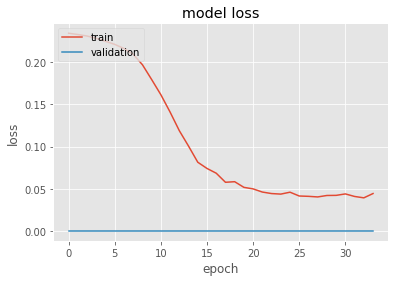

In [ ]:
import matplotlib.pyplot as plt
print(model.history.history.keys())

plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
output_pred = []
def reemovNestings(l): 
    for i in l: 
        if type(i) == list: 
            reemovNestings(i) 
        else: 
            output_pred.append(i)
input_ = input("Type in a headline:")
new_t = Tokenizer()
new_t.fit_on_texts([input_])
tokens = [i for i in new_t.word_index.keys()]
#		print(tokens)
actual_tokens = new_t.texts_to_sequences([input_])
inv_map_tokens = {v: k for k, v in new_t.word_index.items()}
actual_tokens = [inv_map_tokens[i] for i in actual_tokens[0]]
tokens = actual_tokens
input_ = tokenizer.texts_to_sequences([input_])
input_ = pad_sequences(input_, padding = "post", truncating = "post", maxlen = 500, value = 0)
output = loaded_model.predict([input_])
output = output.tolist()
reemovNestings(output)
print(output_pred)
genome_tags['score'] = output_pred
genome_tags

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Type in a headline:Sartaj Singh, a Mumbai police officer, receives an anonymous phone call from a gangster who threatens to blow up the entire city. Amid the corrupt standards of Indian law enforcement begins a battle between a 'nobody' cop and ruthless gangster who perceives (sometimes) himself to be a God.
[0.5291510224342346, 0.4556431472301483, 0.5153481364250183, 0.4766722619533539, 0.4980277419090271, 0.5067722201347351, 0.49445995688438416, 0.46300914883613586, 0.49219924211502075, 0.48933905363082886, 0.4822453558444977, 0.4982876479625702, 0.48964163661003113, 0.49094468355178833, 0.48928239941596985, 0.4815347492694855, 0.4596268832683563, 0.46054935455322266, 0.5207793712615967, 0.5364999175071716, 0.5119513869285583, 0.5097345113754272, 0.48547545075416565, 0.49479010701179504, 0.5465853214263916, 0.5254980325698853, 0.4534824788570404, 0.5333465337753296, 0.47

,tagId,tag,score
0,1,007,0.529151
1,2,007 (series),0.455643
2,3,18th century,0.515348
3,4,1920s,0.476672
4,5,1930s,0.498028
...,...,...,...
1123,1124,writing,0.504896
1124,1125,wuxia,0.474880
1125,1126,wwii,0.503064
1126,1127,zombie,0.522067


In [ ]:
y_hat[0]

array([0.52978647, 0.4571177 , 0.51454246, 0.475426  , 0.5000681 ,
       0.5092914 , 0.49254715, 0.45771247, 0.48527235, 0.4914808 ,
       0.4829489 , 0.5044062 , 0.49029827, 0.49527434, 0.4906817 ,
       0.47338256, 0.45642036, 0.45541543, 0.52156997, 0.5351796 ,
       0.50493836, 0.5155109 , 0.48447353, 0.4906879 , 0.54799217,
       0.5223508 , 0.4556455 , 0.5273489 , 0.47761685, 0.5187596 ,
       0.5039843 , 0.47404248, 0.51488674, 0.50023186, 0.48526487,
       0.48262274, 0.5190196 , 0.4976889 , 0.5398753 , 0.52165836,
       0.54379797, 0.5027747 , 0.47691768, 0.48055696, 0.50617737,
       0.5018332 , 0.48619285, 0.50598615, 0.46835777, 0.48651668,
       0.5365271 , 0.5354549 , 0.50024366, 0.49112722, 0.49763635,
       0.4872363 , 0.46656266, 0.49548662, 0.48098394, 0.53529537,
       0.5173058 , 0.51332927, 0.53454256, 0.49346298, 0.49212575,
       0.5354295 , 0.5059965 , 0.5037043 , 0.47750592, 0.51295257,
       0.51311773, 0.5508309 , 0.5171377 , 0.4795404 , 0.51574

In [ ]:
y_test[0]

array([0.059  , 0.05175, 0.024  , 0.027  , 0.049  , 0.0295 , 0.0205 ,
       0.051  , 0.0205 , 0.02   , 0.0255 , 0.02275, 0.116  , 0.01375,
       0.00225, 0.01975, 0.0085 , 0.07875, 0.8845 , 0.5785 , 0.22575,
       0.18725, 0.1    , 0.03225, 0.03975, 0.057  , 0.08175, 0.12275,
       0.24075, 0.0875 , 0.005  , 0.02225, 0.043  , 0.0215 , 0.02925,
       0.082  , 0.03925, 0.06825, 0.035  , 0.011  , 0.0185 , 0.0205 ,
       0.03025, 0.02425, 0.03325, 0.086  , 0.0085 , 0.02875, 0.178  ,
       0.1035 , 0.13475, 0.3195 , 0.02925, 0.024  , 0.031  , 0.01375,
       0.02875, 0.05175, 0.08225, 0.01875, 0.01525, 0.088  , 0.008  ,
       0.0265 , 0.0165 , 0.026  , 0.07925, 0.022  , 0.00875, 0.065  ,
       0.008  , 0.0265 , 0.1945 , 0.013  , 0.148  , 0.026  , 0.02975,
       0.02825, 0.042  , 0.018  , 0.14275, 0.2985 , 0.104  , 0.04175,
       0.10875, 0.115  , 0.03625, 0.0105 , 0.0155 , 0.02375, 0.018  ,
       0.0255 , 0.03625, 0.08625, 0.19625, 0.4265 , 0.41225, 0.2515 ,
       0.25275, 0.60